In [1]:
import scanpy as sc
import sys
sys.path.append("/corgi/debojyoti") 
import scSVAE

import math
import anndata

import torch

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

import pandas as pd

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import matplotlib.colors

cmap_cellcycle = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cellcycle", ["yellow", "green", "magenta", "yellow"], N=128) 

In [3]:
#cell cycle genes
cc_mouse = pd.read_csv("/corgi/cellbuster/py/cc_mouse.csv")
cc_mouse = cc_mouse.iloc[:,1:]
cc_mouse.head()
cell_cycle_genes = [g.upper() for g in cc_mouse["symbol"].tolist()]
print(len(cell_cycle_genes))
print(cell_cycle_genes[:5])

93
['GMNN', 'RAD51', 'CDCA7', 'PRIM1', 'SLBP']


In [4]:
if True:
    ### Real data
    adata = sc.read("../scellgen2/data/small_rna.h5ad")
else:
    ### Create artificial data to fit
    num_cell = 1000

    gene1 = [np.random.poisson(int(abs(100*math.sin(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene2 = [np.random.poisson(int(abs(100*math.cos(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene3 = [np.random.poisson(int(abs(100*math.sin(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene4 = [np.random.poisson(int(abs(1+0*math.cos(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]

    X=[gene1,gene2,gene3,gene4]
    adata=anndata.AnnData(np.array(X).T)

    plt.plot(gene1)

In [5]:
adata

AnnData object with n_obs × n_vars = 25109 × 1863
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
# sc.pp.subsample(adata, fraction=0.1)

In [7]:
# adata

In [8]:
sc.pp.filter_genes(adata, min_counts=3)

In [9]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

## Restrict to cell cycle genes

In [11]:
adata.var["highly_variable"] = [True if g in cell_cycle_genes else False for g in adata.var.index.tolist()]
adata = adata[:,adata.var["highly_variable"]]
adata

View of AnnData object with n_obs × n_vars = 25109 × 87
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [12]:
adata = adata.copy()

In [13]:
scSVAE.data.setup_anndata(
    adata,
    layer="counts",
    batch_key = "10xversion",
)

INFO     Using batches from adata.obs["10xversion"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 25109 cells, 87 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/pcddas/miniconda3/envs/scvi-env/lib/python3.7/site-packages/scvi/data/_utils.py:23: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  "This dataset has some empty cells, this might fail inference."


In [14]:
model = scSVAE.model.scSVAE(adata, n_latent = 2)

In [15]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/319:   0%|                                                                                                           | 0/319 [00:00<?, ?it/s]

/home/pcddas/miniconda3/envs/scvi-env/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


Epoch 319/319: 100%|███████████████████████████████████████████████████████████████████████████| 319/319 [30:48<00:00,  5.79s/it, loss=46.7, v_num=1]


In [16]:
# model.history.keys()

In [17]:
model.get_reconstruction_error()

/home/pcddas/miniconda3/envs/scvi-env/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


{'reconstruction_loss': -45.08529305635632}

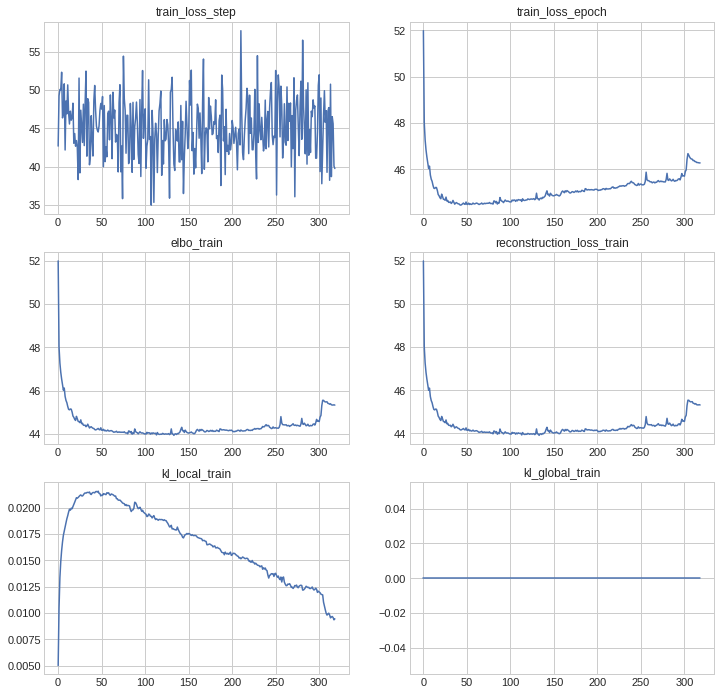

In [18]:
plt.figure(figsize=(12,12))
for i, loss in enumerate(model.history.keys()):
    plt.subplot(3, 2,i+1)
    df = model.history[loss]
    plt.plot(df.iloc[:,0].values)
    plt.title(df.columns.tolist()[0])

In [19]:
latent = model.get_latent_representation()
adata.obsm["X_scSVAE"] = latent

In [20]:
adata.obsm["X_pca"] = latent

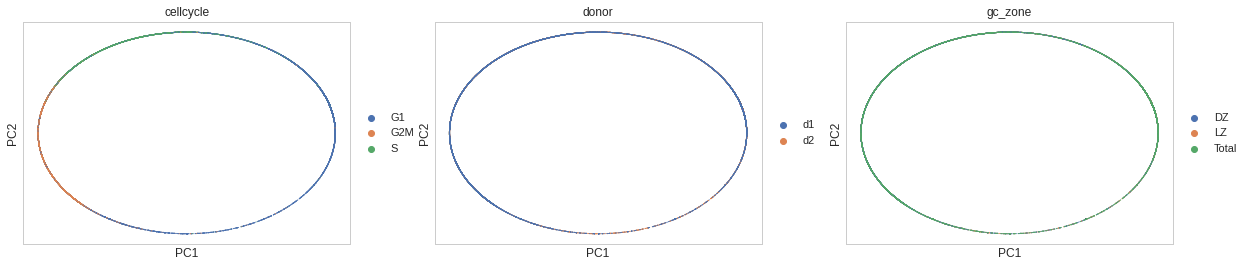

In [21]:
sc.pl.pca(adata, color = ["cellcycle", "donor", "gc_zone"])

## Actual UMAP with PCA co-ordinates

In [22]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

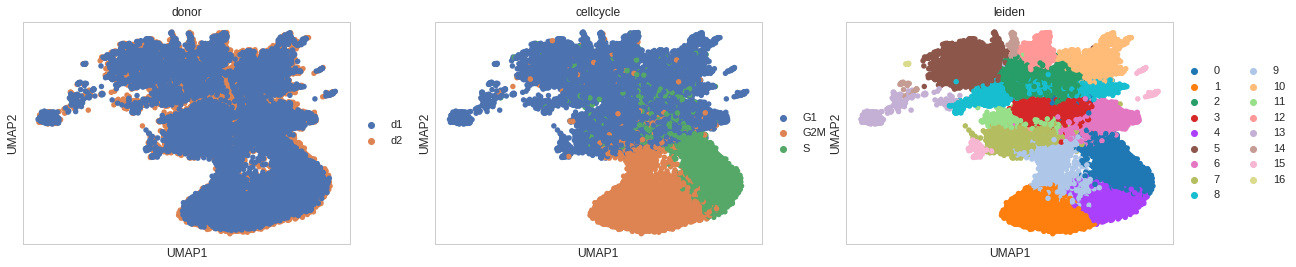

In [23]:
sc.pl.umap(adata, color = ["donor", "cellcycle", "leiden"], size=120)

## Elbow for PCA

In [24]:
# sc.pl.pca_variance_ratio(adata)

## distribution of latent space

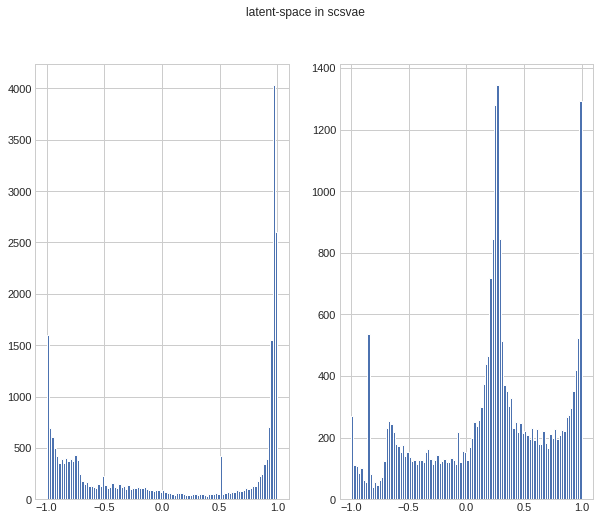

In [25]:
plt.figure(figsize=(10,8))
plt.suptitle("latent-space in scsvae")
plt.subplot(121)
plt.hist(latent[:,0], bins =100)
plt.subplot(122)
plt.hist(latent[:,1], bins =100)
plt.show()

In [26]:
r, theta = model.module.get_polar(adata.obsm["X_scSVAE"][:,0], adata.obsm["X_scSVAE"][:,1])

In [27]:
adata.obs["theta"] = theta

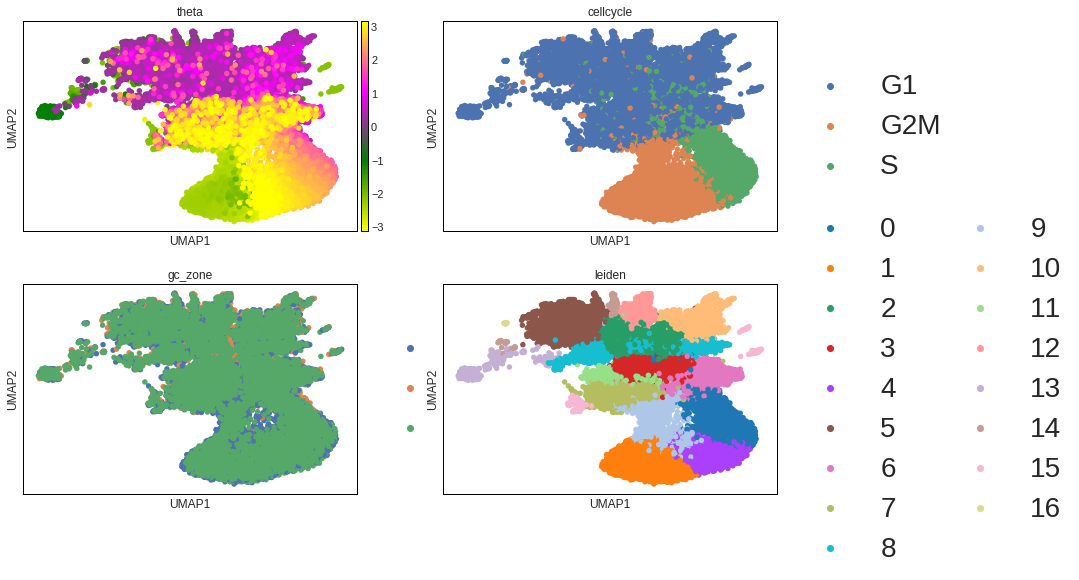

In [28]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['savefig.edgecolor']='black'
plt.rcParams['legend.fontsize']='28'

cmap_cellcycle = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cellcycle", ["yellow", "green", "magenta", "yellow"], N=128)
sc.pl.umap(adata,color=["theta", "cellcycle", "gc_zone", "leiden"], 
           color_map=cmap_cellcycle, ncols=2, size=120)

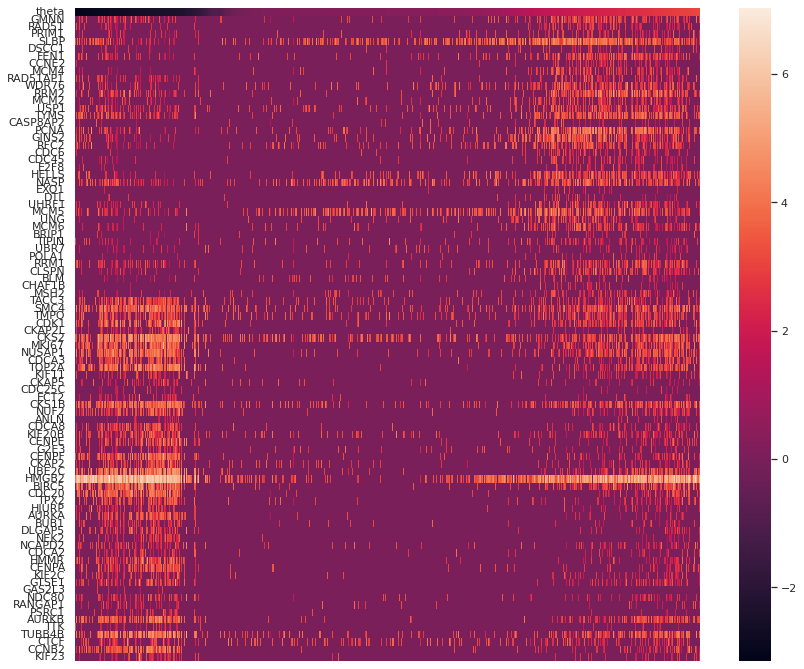

In [29]:
model.module.gene_heatmap(adata, theta, cell_cycle_genes)

In [30]:
# import seaborn as sns
# import seaborn as sns; sns.set_theme()
# import scipy.stats as ss
# import pandas as pd
# import matplotlib.pyplot as plt

In [31]:
# def gene_heatmap(adata, theta, genelist):
    
#     plotdata = pd.DataFrame({"theta": theta})    
#     expression_data = adata.X.todense()

#     for gene in genelist:
#         ind = [i for i,v in enumerate(adata.var.index.tolist()) if v == gene]
#         if ind:

#             expression = expression_data[:,ind[0]]

#             plotdata[gene] = expression


#     plotdata["theta_rank"] = ss.rankdata(plotdata["theta"].tolist())
#     plotdata.sort_values(by=["theta_rank"], inplace = True)
#     plotdata.drop(columns=["theta_rank"], inplace=True)

#     sns.set(font_scale=0.2)
#     sns.set(rc={'figure.figsize':(14,12)})

#     ax = sns.heatmap(plotdata.T, xticklabels=False, yticklabels=1)
#     plt.show()

In [32]:
# gene_heatmap(adata, theta, cell_cycle_genes)